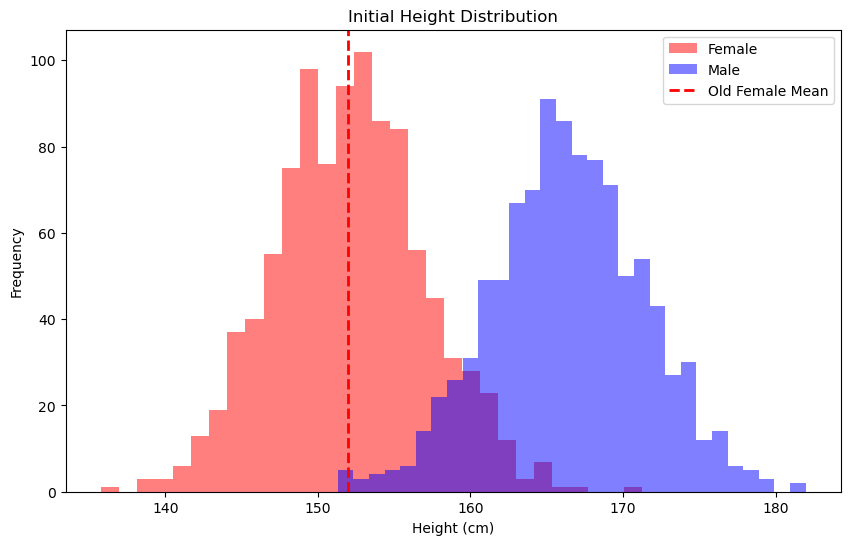

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import norm, zscore
import pandas as pd

np.random.seed(42)
def create_data(mean_of_female, mean_of_male, sd, samples):
    female_heights = np.random.normal(mean_of_female, sd, samples)
    male_heights = np.random.normal(mean_of_male, sd, samples)
    female_labels = ["F"] * samples
    male_labels = ["M"] * samples
    data = np.concatenate([female_heights, male_heights])
    labels = np.concatenate([female_labels, male_labels])
    return data, labels, female_heights, male_heights

mean_of_female, mean_of_male, sd, samples = 152, 166, 5, 1000
data, labels, female_heights, male_heights = create_data(mean_of_female, mean_of_male, sd, samples)

plt.figure(figsize=(10, 6))
plt.hist(female_heights, bins=30, alpha=0.5, label="Female", color='red')
plt.hist(male_heights, bins=30, alpha=0.5, label="Male", color='blue')
plt.axvline(mean_of_female, color='red', linestyle='dashed', linewidth=2, label="Old Female Mean")

plt.xlabel("Height (cm)")
plt.ylabel("Frequency")
plt.title("Initial Height Distribution")
plt.legend()
plt.show()


New Female Mean: 152.5966602791116,

New Female SD: 6.252888523021174 



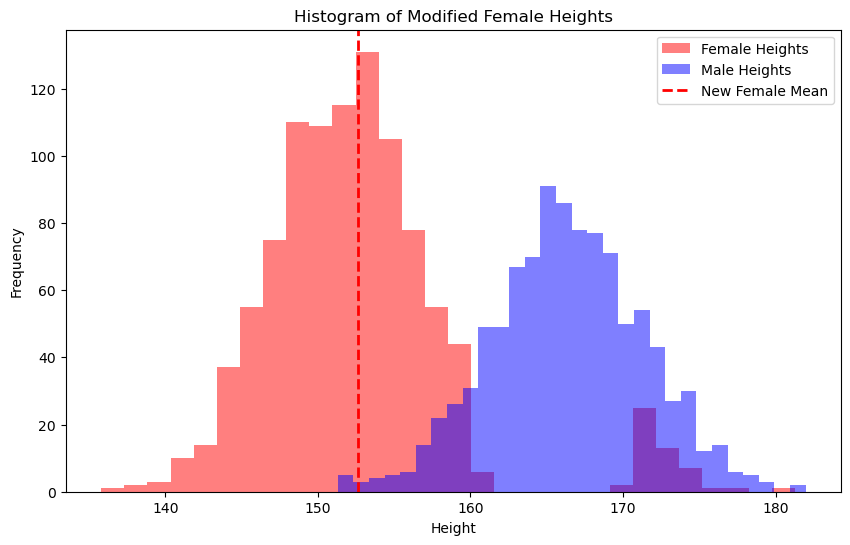

In [6]:
def modifying_top_female_heights(female_heights, incr_by=10, top=50):
    top_indices = np.argsort(female_heights)[-top:]
    female_heights[top_indices] += incr_by
    return female_heights

female_heights = modifying_top_female_heights(female_heights, incr_by=10)
data = np.concatenate([female_heights, male_heights])

new_mean_female = np.mean(female_heights)
new_sd_female = np.std(female_heights)
print(f"New Female Mean: {new_mean_female},\n")
print(f"New Female SD: {new_sd_female} \n")

plt.figure(figsize=(10, 6))
plt.hist(female_heights, bins=30, alpha=0.5, label="Female Heights", color="red")
plt.hist(male_heights, bins=30, alpha=0.5, label="Male Heights", color="blue")
plt.axvline(new_mean_female, color='red', linestyle='dashed', linewidth=2, label="New Female Mean")

plt.title("Histogram of Modified Female Heights")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
def gaussian_likelihood_classification(data, mean_f, mean_m, sd_f, sd_m):
    females = norm.pdf(data, mean_f, sd_f)
    males = norm.pdf(data, mean_m, sd_m)
    return np.where(females > males, "F", "M")

def threshold_classification(threshold, data):
    return np.where(data < threshold, "F", "M")

def classification_accuracy(labels, predictions):
    cm = confusion_matrix(labels, predictions, labels=["F", "M"])
    accuracy = np.trace(cm) / np.sum(cm)
    return accuracy, cm
    
pred_gaussian_before = gaussian_likelihood_classification(data, mean_of_female, mean_of_male, sd, sd)
accuracy_gaussian_before, cm_gaussian_before = classification_accuracy(labels, pred_gaussian_before)
print("Gaussian Accuracy before Modification:", accuracy_gaussian_before*100,"%")
print("Confusion Matrix before Modification:\n", cm_gaussian_before,"\n")

pred_gaussian_after = gaussian_likelihood_classification(data, new_mean_female, mean_of_male, new_sd_female, sd)
accuracy_gaussian_after, cm_gaussian_after = classification_accuracy(labels, pred_gaussian_after)
print("Gaussian Accuracy after Modification:", accuracy_gaussian_after*100,"%")
print("Confusion Matrix after Modification:\n", cm_gaussian_after,"\n")

old_threshold=(mean_of_female+mean_of_male)/2
old_pred_threshold= threshold_classification(old_threshold, data)
old_accuracy_threshold, old_cm_threshold = classification_accuracy(labels, old_pred_threshold)
print("Before Threshold Classification Accuracy:", old_accuracy_threshold*100,"%")
print("Confusion Matrix Threshold:\n", old_cm_threshold,"\n")

threshold = (new_mean_female + mean_of_male) / 2
pred_threshold = threshold_classification(threshold, data)
accuracy_threshold, cm_threshold = classification_accuracy(labels, pred_threshold)
print("After Threshold Classification Accuracy:", accuracy_threshold*100,"%")
print("Confusion Matrix Threshold:\n", cm_threshold,"\n")


Gaussian Accuracy before Modification: 91.85 %
Confusion Matrix before Modification:
 [[909  91]
 [ 72 928]] 

Gaussian Accuracy after Modification: 92.05 %
Confusion Matrix after Modification:
 [[928  72]
 [ 87 913]] 

Before Threshold Classification Accuracy: 91.85 %
Confusion Matrix Threshold:
 [[909  91]
 [ 72 928]] 

After Threshold Classification Accuracy: 92.0 %
Confusion Matrix Threshold:
 [[920  80]
 [ 80 920]] 



Interval: 302, Female Count: 26, Male Count: 2, Error: 2, Total Misclassification: 2
Interval: 303, Female Count: 45, Male Count: 3, Error: 3, Total Misclassification: 5
Interval: 304, Female Count: 47, Male Count: 1, Error: 1, Total Misclassification: 6
Interval: 305, Female Count: 38, Male Count: 0, Error: 0, Total Misclassification: 6
Interval: 306, Female Count: 46, Male Count: 3, Error: 3, Total Misclassification: 9
Interval: 307, Female Count: 42, Male Count: 2, Error: 2, Total Misclassification: 11
Interval: 308, Female Count: 31, Male Count: 1, Error: 1, Total Misclassification: 12
Interval: 309, Female Count: 32, Male Count: 0, Error: 0, Total Misclassification: 12
Interval: 310, Female Count: 41, Male Count: 6, Error: 6, Total Misclassification: 18
Interval: 311, Female Count: 30, Male Count: 0, Error: 0, Total Misclassification: 18
Interval: 312, Female Count: 29, Male Count: 5, Error: 5, Total Misclassification: 23
Interval: 313, Female Count: 19, Male Count: 8, Error: 8, T

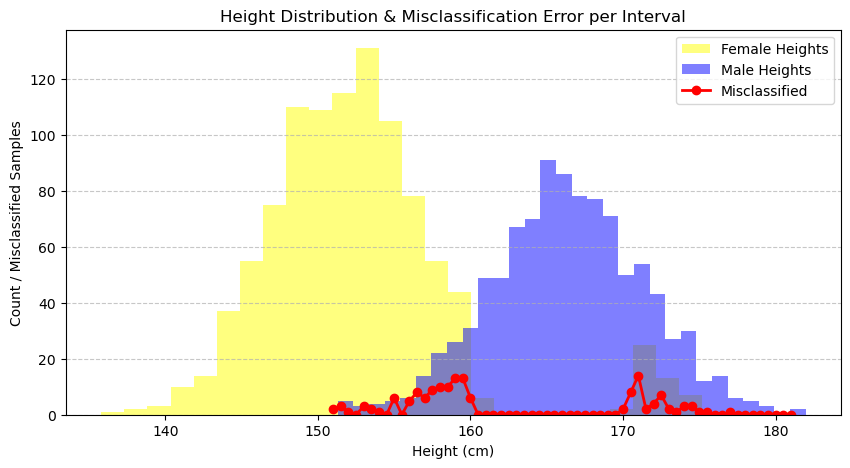

In [11]:
def quantize(heights, interval_len):
    interval_labels = np.floor(heights / interval_len)
    interval_counts = pd.Series(interval_labels).value_counts().sort_index()
    return interval_counts

def local_classifier(interval_len, female_heights, male_heights):
    total = female_heights.size + male_heights.size
    male_quantized = quantize(male_heights, interval_len)
    female_quantized = quantize(female_heights, interval_len)
    
    quantized_lower_bound = int(male_quantized.index.min())
    quantized_upper_bound = int(female_quantized.index.max())
    
    total_misclassification = 0
    errors = []
    
    for common_interval in range(quantized_lower_bound, quantized_upper_bound + 1, 1):
        female_count = female_quantized.get(common_interval, 0)
        male_count = male_quantized.get(common_interval, 0)
        error = min(female_count, male_count)
        total_misclassification += error
        errors.append((common_interval * interval_len, error))
        print(f"Interval: {common_interval}, Female Count: {female_count}, Male Count: {male_count}, Error: {error}, Total Misclassification: {total_misclassification}")
    
    misclassification_rate = 100.0 * total_misclassification / total
    return misclassification_rate, errors
    
interval_len = 0.5
misclassification_rate, errors = local_classifier(interval_len, female_heights, male_heights)


print(f"Total Misclassification Rate after modification: {misclassification_rate:.2f}%")

interval_values, error_values = zip(*errors)
plt.figure(figsize=(10, 5))
plt.hist(female_heights, bins=30, alpha=0.5, label="Female Heights", color='yellow')
plt.hist(male_heights, bins=30, alpha=0.5, label="Male Heights", color='blue')
plt.plot(interval_values, error_values, marker='o', color="red", linestyle='-', linewidth=2, label="Misclassified")
plt.xlabel("Height (cm)")
plt.ylabel("Count / Misclassified Samples")
plt.title("Height Distribution & Misclassification Error per Interval")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


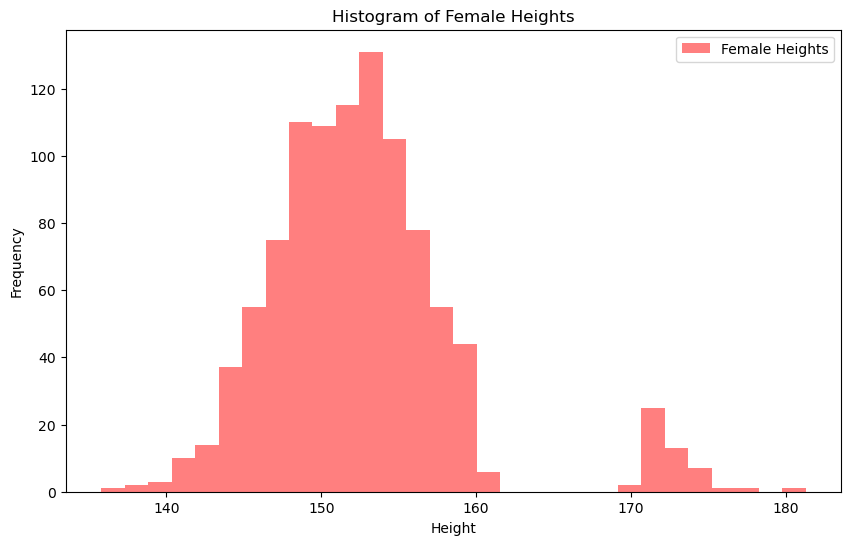

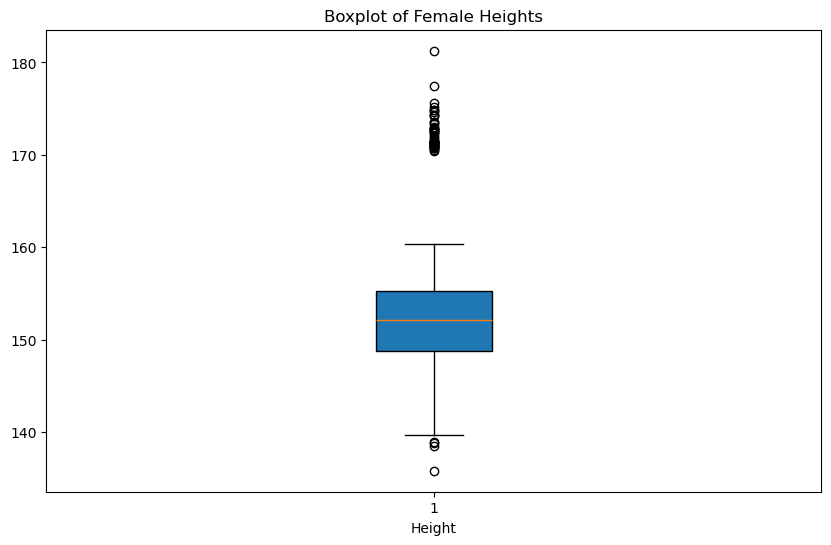

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(female_heights, bins=30, alpha=0.5, color="red", label="Female Heights")
plt.title("Histogram of Female Heights")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()
print("\n")
plt.figure(figsize=(10, 6))
plt.boxplot(female_heights, vert=True, patch_artist=True)
plt.title("Boxplot of Female Heights")
plt.xlabel("Height")
plt.show()


In [14]:
z_scores = zscore(female_heights)

outlier1 = female_heights[np.abs(z_scores) > 2]
outlier2 = female_heights[np.abs(z_scores) > 3]

print("Outliers of Z-score > 2:", outlier1)
print("Outliers of Z-score > 3:", outlier2)


Outliers of Z-score > 2: [171.26139092 138.90127448 171.43092951 174.31621056 172.95227813
 171.32887256 171.48396491 175.60084583 181.26365745 173.57329283
 172.71972045 170.8272712  172.61078099 135.7936633  172.66516687
 172.46193638 172.76591229 172.94901467 171.3808542  171.15729383
 172.30373962 170.77670421 171.82362566 177.39440404 170.43570818
 171.5470832  139.6417775  172.37700399 173.35346429 171.38397906
 174.2287599  171.41012248 138.51556679 171.24478047 174.86679902
 138.74515096 170.76135222 170.77397091 170.48228184 175.16191032
 174.80042269 170.85400318 171.06224279 173.49449062 174.2765007
 170.97938837 172.05102269 170.97278932 174.63466213 171.23353663
 172.81627362 171.40578535 171.23318498 171.00470216 139.88060337
 170.98843263]
Outliers of Z-score > 3: [171.43092951 174.31621056 172.95227813 171.48396491 175.60084583
 181.26365745 173.57329283 172.71972045 172.61078099 172.66516687
 172.46193638 172.76591229 172.94901467 171.3808542  172.30373962
 171.8236256

In [17]:
Quartile1 = np.percentile(female_heights, 25)
Quartile3 = np.percentile(female_heights, 75)
IQR = Quartile3 - Quartile1

lower_bound1 = Quartile1 - 1.5 * IQR
upper_bound1 = Quartile3 + 1.5 * IQR

lower_bound2 = Quartile1 - 2 * IQR
upper_bound2 = Quartile3 + 2 * IQR

lower_bound3 = Quartile1 - 3 * IQR
upper_bound3 = Quartile3 + 3 * IQR

outliers_iqr1 = female_heights[(female_heights < lower_bound1) | (female_heights > upper_bound1)]
outliers_iqr2 = female_heights[(female_heights < lower_bound2) | (female_heights > upper_bound2)]
outliers_iqr3 = female_heights[(female_heights < lower_bound3) | (female_heights > upper_bound3)]
print("Outliers using IQR Method:", outliers_iqr1,"\n")
print("Outliers using IQR Method:", outliers_iqr2,"\n")
print("Outliers using IQR Method:", outliers_iqr3,"\n")


Outliers using IQR Method: [171.26139092 138.90127448 171.43092951 174.31621056 172.95227813
 171.32887256 171.48396491 175.60084583 181.26365745 173.57329283
 172.71972045 170.8272712  172.61078099 135.7936633  172.66516687
 172.46193638 172.76591229 172.94901467 171.3808542  171.15729383
 172.30373962 170.77670421 171.82362566 177.39440404 170.43570818
 171.5470832  172.37700399 173.35346429 171.38397906 174.2287599
 171.41012248 138.51556679 171.24478047 174.86679902 138.74515096
 170.76135222 170.77397091 170.48228184 175.16191032 174.80042269
 170.85400318 171.06224279 173.49449062 174.2765007  170.97938837
 172.05102269 170.97278932 174.63466213 171.23353663 172.81627362
 171.40578535 171.23318498 171.00470216 170.98843263] 

Outliers using IQR Method: [171.26139092 171.43092951 174.31621056 172.95227813 171.32887256
 171.48396491 175.60084583 181.26365745 173.57329283 172.71972045
 170.8272712  172.61078099 135.7936633  172.66516687 172.46193638
 172.76591229 172.94901467 171.38

Number of data points before: 1000
Number of data points after Z-score removal: 944


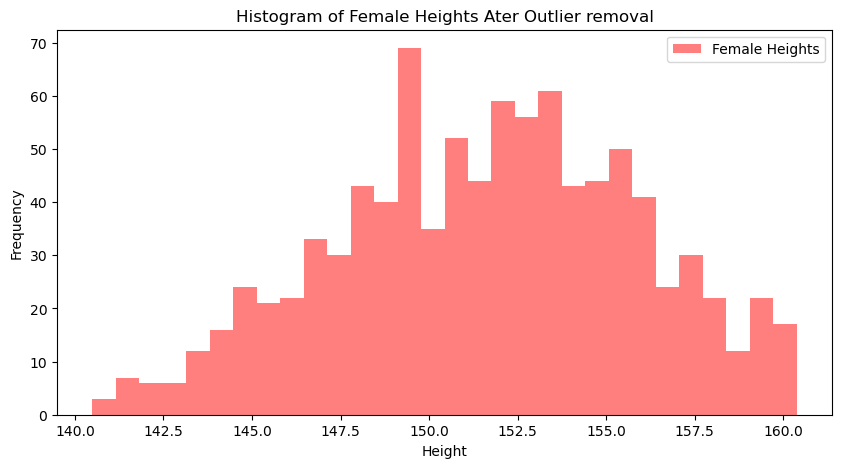

In [19]:
z_scores = zscore(female_heights)
threshold_z = 2

removing_outliers = female_heights[np.abs(z_scores) <= threshold_z]

print(f"Number of data points before: {len(female_heights)}")
print(f"Number of data points after Z-score removal: {len(removing_outliers)}")

plt.figure(figsize=(10, 5))

plt.hist(removing_outliers, bins=30, alpha=0.5, color="red", label="Female Heights")
plt.title("Histogram of Female Heights Ater Outlier removal")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Number of data points before: 1000
Number of data points after Z-score removal: 968


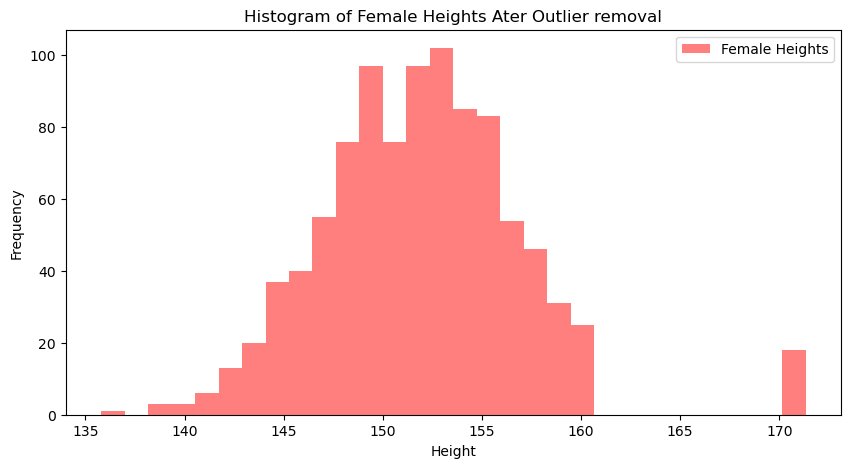

In [20]:
z_scores = zscore(female_heights)
threshold_z = 3

removing_outliers = female_heights[np.abs(z_scores) <= threshold_z]

print(f"Number of data points before: {len(female_heights)}")
print(f"Number of data points after Z-score removal: {len(removing_outliers)}")
plt.figure(figsize=(10, 5))

plt.hist(removing_outliers, bins=30, alpha=0.5, color="red", label="Female Heights")
plt.title("Histogram of Female Heights Ater Outlier removal")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Number of data points before: 1000
Number of data points after IQR removal: 946


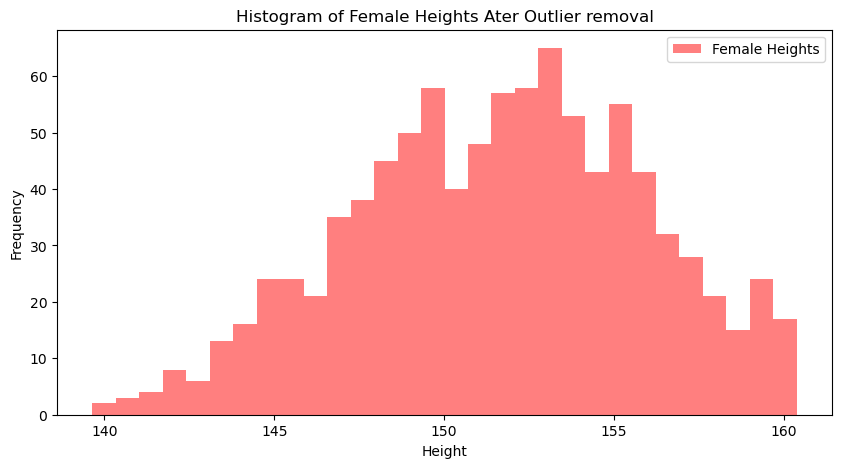

In [22]:
Q1 = np.percentile(female_heights, 25)
Q3 = np.percentile(female_heights, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

removing_outlier_using_iqr = female_heights[(female_heights >= lower_bound) & (female_heights <= upper_bound)]

print(f"Number of data points before: {len(female_heights)}")
print(f"Number of data points after IQR removal: {len(removing_outlier_using_iqr)}")

plt.figure(figsize=(10, 5))

plt.hist(removing_outlier_using_iqr, bins=30, alpha=0.5, color="red", label="Female Heights")
plt.title("Histogram of Female Heights Ater Outlier removal")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Number of data points before: 1000
Number of data points after MAD removal: 928


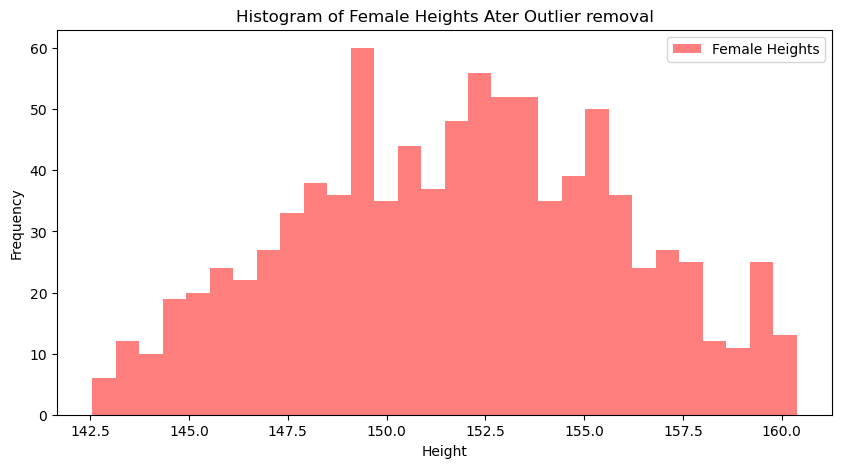

In [24]:
median_female = np.median(female_heights)
mad_female = np.median(np.abs(female_heights - median_female))

threshold_mad = 3

removing_outlier_using_MAD = female_heights[np.abs(female_heights - median_female) <= threshold_mad * mad_female]

print(f"Number of data points before: {len(female_heights)}")
print(f"Number of data points after MAD removal: {len(removing_outlier_using_MAD)}")

plt.figure(figsize=(10, 5))

plt.hist(removing_outlier_using_MAD, bins=30, alpha=0.5, color="red", label="Female Heights")
plt.title("Histogram of Female Heights Ater Outlier removal")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [26]:

mean_z = np.mean(removing_outliers)
print("Mean",mean_z)
sd_z = np.std(removing_outliers)
print("SD",sd_z)
pred_z = gaussian_likelihood_classification(data, mean_z, mean_of_female, sd_z, sd)
gaussian_mat_z = confusion_matrix(labels, pred_z, labels=["F", "M"])
accuracy_z = np.trace(gaussian_mat_z) / np.sum(gaussian_mat_z)
print(f"Gaussian Accuracy after Z-score Removal: {accuracy_z*100}%","\n")


mean_iqr = np.mean(removing_outlier_using_iqr)
print("Mean",mean_iqr)
sd_iqr = np.std(removing_outlier_using_iqr)
print("SD",sd_iqr)
pred_iqr = gaussian_likelihood_classification(data, mean_iqr, mean_of_female, sd_iqr, sd)
gaussian_mat_iqr = confusion_matrix(labels, pred_iqr, labels=["F", "M"])
accuracy_iqr = np.trace(gaussian_mat_iqr) / np.sum(gaussian_mat_iqr)
print(f"Gaussian Accuracy after IQR Removal: {accuracy_iqr*100}%","\n")


mean_mad = np.mean(removing_outlier_using_MAD)
print("Mean",mean_mad)
sd_mad = np.std(removing_outlier_using_MAD)
print("SD",sd_mad)
pred_mad = gaussian_likelihood_classification(data, mean_mad, mean_of_female, sd_mad, sd)
gaussian_mat_mad = confusion_matrix(labels, pred_mad, labels=["F", "M"])
accuracy_mad = np.trace(gaussian_mat_iqr) / np.sum(gaussian_mat_mad)
print(f"Gaussian Accuracy after MAD Removal: {accuracy_mad*100}%","\n")


threshold_z = (mean_z + mean_of_female) / 2
pred_threshold_z = threshold_classification(threshold_z, data)
accuracy_threshold_z, cm_threshold_z = classification_accuracy(labels, pred_threshold_z)
print(f"Threshold Accuracy after Z-score Removal: {accuracy_threshold_z * 100}%", "\n")

threshold_iqr = (mean_iqr + mean_of_female) / 2
pred_threshold_iqr = threshold_classification(threshold_iqr, data)
accuracy_threshold_iqr, cm_threshold_iqr = classification_accuracy(labels, pred_threshold_iqr)
print(f"Threshold Accuracy after IQR Removal: {accuracy_threshold_iqr * 100}%", "\n")

threshold_mad = (mean_mad + mean_of_female) / 2
pred_threshold_mad = threshold_classification(threshold_mad, data)
accuracy_threshold_mad, cm_threshold_mad = classification_accuracy(labels, pred_threshold_mad)
print(f"Threshold Accuracy after MAD Removal: {accuracy_threshold_mad * 100}%", "\n")



Mean 151.91028477753372
SD 5.053083062752024
Gaussian Accuracy after Z-score Removal: 30.45% 

Mean 151.6065772756146
SD 4.277709763813894
Gaussian Accuracy after IQR Removal: 82.15% 

Mean 151.80276980998934
SD 4.076610210972169
Gaussian Accuracy after MAD Removal: 82.15% 

Threshold Accuracy after Z-score Removal: 74.15% 

Threshold Accuracy after IQR Removal: 73.35000000000001% 

Threshold Accuracy after MAD Removal: 73.9% 



[91.78571428571428] % 

[91.78571428571428, 91.66666666666666] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666, 91.81818181818183] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666, 91.81818181818183, 91.86046511627907] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666, 91.81818181818183, 91.86046511627907, 91.72619047619047] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666, 91.81818181818183, 91.86046511627907, 91.72619047619047, 91.70731707317074] % 

[91.78571428571428, 91.66666666666666, 91.70212765957447, 91.68478260869564, 91.66666666666666, 91.8

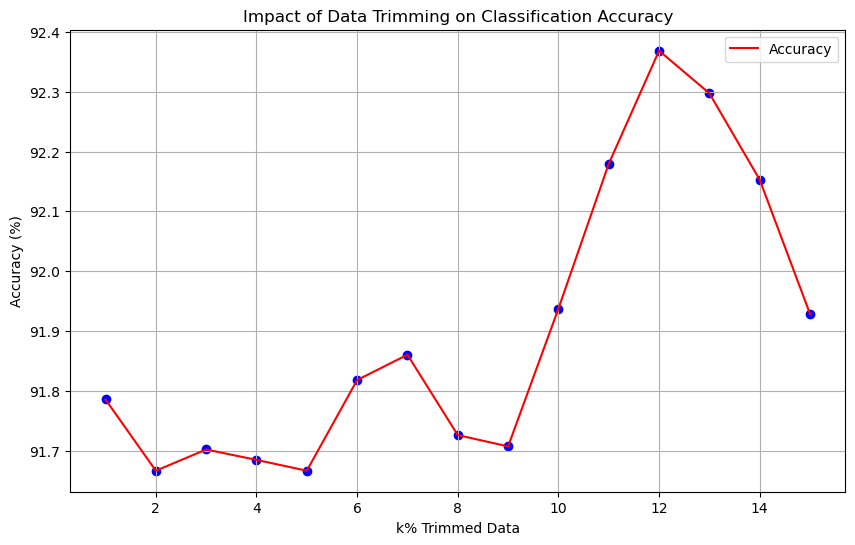

In [28]:
def trim_data(data, labels, k):
    lower_bound = np.percentile(data, k)  
    upper_bound = np.percentile(data, 100 - k) 
    
    trimmed_data = data[(data >= lower_bound) & (data <= upper_bound)]
    trimmed_labels = labels[(data >= lower_bound) & (data <= upper_bound)]
    return trimmed_data, trimmed_labels

k_values = np.arange(1, 16)  
accuracies = []

for k in k_values:
    trimmed_data, trimmed_labels = trim_data(data, labels, k)
    pred = gaussian_likelihood_classification(trimmed_data, mean_of_female, mean_of_male, sd, sd)
    accuracy, cm = classification_accuracy(trimmed_labels, pred)
    accuracies.append(accuracy * 100)  
    print(accuracies,"% \n")

plt.figure(figsize=(10, 6))
plt.scatter(k_values, accuracies, color='blue', marker='o')
plt.plot(k_values, accuracies, linestyle='-', color='red', label='Accuracy')
plt.xlabel("k% Trimmed Data")
plt.ylabel("Accuracy (%)")
plt.title("Impact of Data Trimming on Classification Accuracy")
plt.legend()
plt.grid(True)
plt.show()
